# Using Collaborative Filtering to Recommend Alternative Movies

## Case Study
The customer service team at Netflix has started to receive user complaints about Netflix having a limited catalog of movies. In response, the product team has decided that they want to suggest similar movies as a consolation to users that can't find their desired movie. The product team has asked their top two data scientist, Debbie and Juan Carlos, to create an algorithm that allows a user to receive suggested movies when their searched for movie is not available.


## Stakeholders
1. Product Team: This team has requested the ability to provide a user with suggested movies when the user is not able to find the specific movie they want to watch.
2. Customer Service Team: This team expects that the new feature will reduce the number of user complains about the movies not being available on their library.

## Success Metrics
* The number of user complaints related to a movie not being available should show statistically significant decreases after the feature is implemented.
* The number of people that watch a recommended movie should increase while the number of user complaints decreases.

In [1]:
# All the following libraries mush be imported
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import itertools
from timeit import default_timer as timer

from surprise import SVD
from surprise import KNNWithMeans
from surprise import Reader, Dataset
from surprise import evaluate, print_perf, GridSearch
from surprise import accuracy


In [2]:
if os.getcwd().split('/')[-1] == 'part_1':
    print('Congratulations! You are in the correct working directory.')
else:
    print('Please reopen the notebook from the \'part_1\' directory \
    using the command listed in the README')

Congratulations! You are in the correct working directory.


First, we will build a neighborhood user-based model. Put simply, this means that our recommendations for a given user "Bob" will be based on the ratings of people who have similar taste in movies as Bob. This set of people are Bob's neighbors, and we will use the mean neighbor ratings for a given movie X to estimate what rating Bob will give movie X. If Bob's predicted rating is high then this is a movie we will recommend to Bob because we think he would like it.

Let's import our data. We are using movielens data to prototype our model (https://grouplens.org/datasets/movielens/100k/). Before we do any model building, we need to think carefully about how we split the data. We will set aside a portion of the data (say, 20%) to be our "test" data. This test data will be untouched while we build our model, and we'll only use it at the end when we want to see how well our model did at predicting on fresh data. As for the other 80% of the dataset, we can split this further into "train" and "tune" data. We will train our model on the training dataset, check accuracy on the tuning dataset, then we can iteratively improve the model accuracy through hyper parameter optimization.

In [3]:
files_dir = os.path.expanduser('./data/')
reader = Reader(line_format='user item rating', sep=',')

train_file = files_dir + 'ratings_train.csv'
test_file = files_dir + 'ratings_test.csv'

folds_files = [(train_file, test_file)]
data = Dataset.load_from_folds(folds_files, reader=reader)

We have selected KNN with means for our first algorithm. This is a k nearest neighbors user-based model that takes into account each user's mean rating. So overly pessimistic or optimistic people will not bias the recommendations.

<img src="img/kNN_mean_formula.png", width = 400, height=400>

In [4]:
sim_options = {'name': 'pearson',
               'user_based': True  # compute  similarities between users
               }

algo = KNNWithMeans(sim_options=sim_options)

In [5]:
for trainset, testset in data.folds():

    # train and test algorithm.
    algo.train(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)  

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9145


We are using RMSE, or root mean squared error to measure accuracy. RMSE penalizes outliers, which makes sense for our use case, which is to present alternative movies when a movie is unavailable in our catalog. Optimizing for RMSE would prevent our model from making outlier suggestions (suggesting to a user a movie that they would've rated a 1). Since the user might be upset already that their desired movie isn't available, we don't want to anger them further by making a wildly off-base recommendation.

We should also consider coverage, or in our case, the percentage of users who receive an adequate number of recommendations. If we decide to show each user their top 10 recommended movies, what percentage of users will actually receive 10 recommendations?

In [6]:
from collections import defaultdict

def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)

users = []
num_recs = []

for uid, user_ratings in top_n.items():
    users.append(uid)
    num_recs.append(len(user_ratings))


In [7]:
coverage = pd.DataFrame(list(zip(users, num_recs)),
              columns=['uid','num_recs'])
coverage['under10'] = np.where(coverage['num_recs']<10, 'yes', 'no')
pd.value_counts(coverage['under10'].values, sort=False)

no     436
yes    234
dtype: int64

65% of our users will receive more than 10 recommended movies, so this is our user coverage. Obviously this number will improve if we decide to show fewer than 10 recommended movies. This coverage percentage doesn't seem very high, I think we can do better on this.

## Hyperparameter optimization

Now that we've established a baseline, let's do some hyperparameter optimization to make our model even better. We will split our training data into 3 folds. For KNN with means, the main parameters we can tweak are k, and min-k. k is the maximum number of neighbors to take into account. min-k is the minimum number of neighbors needed to make a prediction. In our earlier model, the defaults were set to k=40, min_k = 1.

In [8]:
train_data = Dataset.load_from_file('./data/ratings_train.csv', reader=reader)

#split into folds
train_data.split(n_folds=3)

#generating K's to iterate through, starting at 30 and ending at 100 in interval of 10.
klist = []
for i in range(30,80,10):
    klist.append(i)
    
param_grid = {'k': klist,
              'min_k': [1,2,3,4,5]}

grid_search = GridSearch(KNNWithMeans, param_grid, measures=['RMSE'])

grid_search.evaluate(train_data)

results_df = pd.DataFrame.from_dict(grid_search.cv_results)


[{'k': 30, 'min_k': 1}, {'k': 30, 'min_k': 2}, {'k': 30, 'min_k': 3}, {'k': 30, 'min_k': 4}, {'k': 30, 'min_k': 5}, {'k': 40, 'min_k': 1}, {'k': 40, 'min_k': 2}, {'k': 40, 'min_k': 3}, {'k': 40, 'min_k': 4}, {'k': 40, 'min_k': 5}, {'k': 50, 'min_k': 1}, {'k': 50, 'min_k': 2}, {'k': 50, 'min_k': 3}, {'k': 50, 'min_k': 4}, {'k': 50, 'min_k': 5}, {'k': 60, 'min_k': 1}, {'k': 60, 'min_k': 2}, {'k': 60, 'min_k': 3}, {'k': 60, 'min_k': 4}, {'k': 60, 'min_k': 5}, {'k': 70, 'min_k': 1}, {'k': 70, 'min_k': 2}, {'k': 70, 'min_k': 3}, {'k': 70, 'min_k': 4}, {'k': 70, 'min_k': 5}]
------------
Parameters combination 1 of 25
params:  {'k': 30, 'min_k': 1}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 0.9441
------------
------------
Parameters combination 2 of 25
params:  {'k': 30, 'min_k': 2}
Computing t

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 0.9313
------------
------------
Parameters combination 24 of 25
params:  {'k': 70, 'min_k': 4}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 0.9309
------------
------------
Parameters combination 25 of 25
params:  {'k': 70, 'min_k': 5}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 0.9317
------------


/Users/deborahchung/anaconda/envs/rec/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


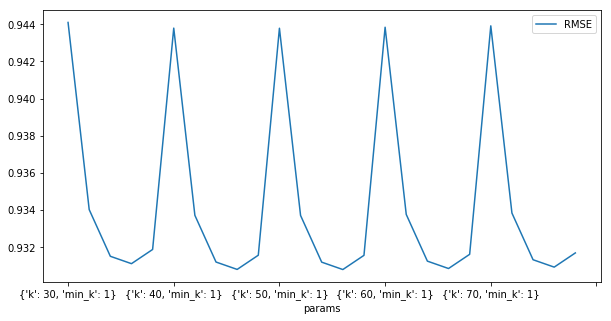

In [9]:
#plot the results of our hyper parameter optimization
results_df.plot(x=['params'], y=['RMSE'], figsize=(10, 5))
plt.show()

From left to right on the graph above, different pairs of k and min-k are plotted to show how the RMSE is changing. Starting at the lowest k value and lowest min-k (k=30, min-k=1) on the left, the RMSE is relatively high. The number of neighbors being considered is small, and a user only needs to have 1 neighbor to calculate a prediction. This means the predictions will be unstable, since when there is only 1 neighbor, the user will take on the rating from that 1 neighbor. As min-k cycles from 1 to 5, the RMSE drops at min-k = 4. We confirm by finding the argmin for the best k and min-k below.

In [10]:
#find the best parameters
# best RMSE score
print(grid_search.best_score['RMSE'])

# combination of parameters that gave the best RMSE score
print(grid_search.best_params['RMSE'])

0.93078270324
{'k': 50, 'min_k': 4}


Check accuracy on test set using the best parameters found from grid search:

In [11]:
sim_options = {'name': 'pearson',
               'user_based': True  # compute  similarities between users
               }

algo = KNNWithMeans(k=40, min_k=4, sim_options=sim_options)

for trainset, testset in data.folds():

    # train and test algorithm.
    algo.train(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)  


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9053


## How does the model scale from small data to larger data?


In [12]:
from timeit import default_timer as timer

data = Dataset.load_builtin('ml-100k')
raw_ratings = data.raw_ratings

samples = []
acc = []
timing = []
for i in range(1,10,1):
    start = timer()
    threshold = int((i/10) * len(raw_ratings))
    A_raw_ratings = raw_ratings[:threshold]
    B_raw_ratings = raw_ratings[threshold:]
    
    samples.append(threshold)

    data.raw_ratings = A_raw_ratings  # data is now the set A
    data.split(n_folds=3)

    sim_options = {'name': 'pearson',
                   'user_based': True  # compute  similarities between users
                   }

    #using best parameters from grid search
    algo = KNNWithMeans(k=40, min_k=4, sim_options=sim_options)

    # retrain on the whole set A
    trainset = data.build_full_trainset()
    algo.train(trainset)
    end = timer()
    timing.append(end - start) 

    # Compute unbiased accuracy on B
    testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
    predictions = algo.test(testset)
#     accuracy.rmse(predictions)
    acc.append(accuracy.rmse(predictions))
    

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1015
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0701
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0578
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0402
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0321
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9947
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9559
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9460
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9433


/Users/deborahchung/anaconda/envs/rec/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


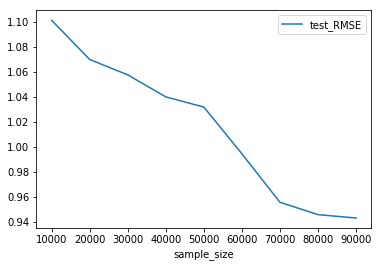

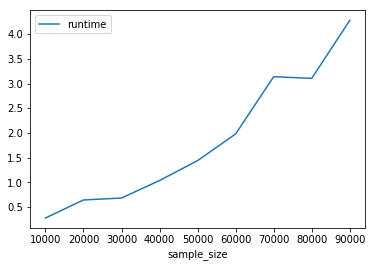

In [13]:
sample_acc = pd.DataFrame(list(zip(samples, acc, timing)),
              columns=['sample_size','test_RMSE', 'runtime'])

sample_acc.plot(x=['sample_size'], y=['test_RMSE'])
sample_acc.plot(x=['sample_size'], y=['runtime'])

plt.show()


As you can see in the graphs above, as the size of the data being sampled gets larger, error gets lower (accuracy gets better). This makes sense because the model is being trained on a larger base of data and is more stable (central limit theorem). Accordingly, the runtime also increases because the model is finding neighbors for more users as the data gets larger.

## So how did we do with our model?
The RMSE is low, at 0.9. However runtime appears to increaes rapidly as sample size increases, so this algorithm may not scale well.
Another thing to watch out for is that this type of model may recommend the "lowest common denominator" movie - in other words, a movie that is unobjectionable but not particularly close to the user's specific taste.

## Let's try another method of collaborative filtering: Matrix Factorization


### Import Data
Note that a new movie ID has been created for this algorithm in order to reduce the dimmension of the matrix and maintian a relationship between the column number and the movie ID

In [14]:
# import the movie names data set

movies = pd.read_csv('./data/movies_newid')
movies.head()

,new_movieId,movieId,title
0,1,1,Toy Story (1995)
1,2,2,Jumanji (1995)
2,3,3,Grumpier Old Men (1995)
3,4,4,Waiting to Exhale (1995)
4,5,5,Father of the Bride Part II (1995)


In [15]:
# Import ratings

rawdata = pd.read_csv('./data/ratings.csv')
# replace the movie ID with the new movie id
rawdata = pd.merge(rawdata,movies[['new_movieId','movieId']],how='left',left_on='movieId',right_on='movieId')
rawdata = rawdata[['userId','new_movieId','rating']].rename(columns={'userId':'user_id', 'new_movieId':'movie_id'})
ratings_full = rawdata

In [16]:
# We split the data into a training set and a test set
# CAUTION: this code may have problems if the random test set contains all the ratings of the last movie. This is highly unlikely.

rawdata_train, rawdata_test = train_test_split(rawdata,test_size=0.2)
#rawdata = pd.read_csv('./data/ratings_train.csv')
print(rawdata_train.shape, ' Train Data')
print(rawdata_test.shape, ' Test Data')
rawdata_train.head()

(80003, 3)  Train Data
(20001, 3)  Test Data


,user_id,movie_id,rating
5731,30,2794,4.0
88807,590,264,4.0
23382,165,1970,3.0
16051,103,892,2.0
17350,113,25,4.0


### SCALING TEST: Test the time of execution with different data sparsities.

In [17]:
# This cell runs the model with datasets of different sizes to test the execution time

#Parameters
ds= 10 # The number of factors
sigmas = 1 # The learning rate
lams = 5 # The regularization parameter
iterations = 50
data_sizes = [.9,.8, .7,.6, .5, .4, .3,.2,.1]

durations = pd.DataFrame(np.zeros((len(data_sizes), 2)), columns=['percent_of_data', 'Time in seconds'])
# MODEL

# Now we run the model for different sizes size data set
for row, keep in enumerate(data_sizes):
    
    # We now create the appropriate matrcies to for the training data and the test data

    #First we create two empty matrix (train  & test) with the same dimmesions.
    rawdata_train2, delme = train_test_split(rawdata_train, train_size=keep)
    rawdata=rawdata_train2
    M = np.zeros((ratings_full.user_id.max()+1,movies.new_movieId.max()+1))
    M[:,:] = np.nan


    # Now we populate the training matrix with training ratings
    rawdata = np.asanyarray(rawdata)
    for uid, mid, rating in rawdata:
        M[int(uid),int(mid)] = rating

    # We make use of masks to easily identify the cells with an actual rating
    MTF = ~np.isnan(M)
    M0 = np.nan_to_num(M)

    # Set Variables
    d = ds
    sigma = sigmas
    lam = lams

    #Initialize U and V
    U = np.random.randn(M.shape[0],d)
    V = np.random.randn(d,M.shape[1])
    
    omega = np.nan_to_num(np.divide(M,M))
    objective = np.array([])
    rmse_temp = np.array([])
    
    #
    start = timer()
    for n in range(iterations):
        #
    
        for i in range(M.shape[0]):

            mask = MTF[i,:]
            temp = V[:,mask].dot(V[:,mask].T)
            temp = lam*sigma*np.identity(len(temp)) + temp
            temp = np.linalg.inv(temp)
            temp = temp.dot(V[:,mask].dot(M[i,:][mask]))
            U[i] = temp
        #  
        for j in range(M.shape[1]):

            mask = MTF[:,j]
            temp = U.T[:,mask].dot(U.T[:,mask].T)
            temp = lam*sigma*np.identity(len(temp)) + temp
            temp = np.linalg.inv(temp)
            temp = temp.dot(U.T[:,mask].dot(M[:,j][mask]))
            V[:,j] = temp
        
    
        # Get all my predictions
        Mguess = U.dot(V)
        if (n)%20 ==0:
            print('Iteration: ',n , 'data size: ', keep)
    end = timer()
    duration = [(end-start)]
    durations.iloc[row] = [keep, duration[0]]


#####
durations

/Users/deborahchung/anaconda/envs/rec/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Iteration:  0 data size:  0.9
Iteration:  20 data size:  0.9
Iteration:  40 data size:  0.9
Iteration:  0 data size:  0.8
Iteration:  20 data size:  0.8
Iteration:  40 data size:  0.8
Iteration:  0 data size:  0.7
Iteration:  20 data size:  0.7
Iteration:  40 data size:  0.7
Iteration:  0 data size:  0.6
Iteration:  20 data size:  0.6
Iteration:  40 data size:  0.6
Iteration:  0 data size:  0.5
Iteration:  20 data size:  0.5
Iteration:  40 data size:  0.5
Iteration:  0 data size:  0.4
Iteration:  20 data size:  0.4
Iteration:  40 data size:  0.4
Iteration:  0 data size:  0.3
Iteration:  20 data size:  0.3
Iteration:  40 data size:  0.3
Iteration:  0 data size:  0.2
Iteration:  20 data size:  0.2
Iteration:  40 data size:  0.2
Iteration:  0 data size:  0.1
Iteration:  20 data size:  0.1
Iteration:  40 data size:  0.1


,percent_of_data,Time in seconds
0,0.9,73.617312
1,0.8,83.143971
2,0.7,65.463059
3,0.6,59.936506
4,0.5,56.931615
5,0.4,52.637384
6,0.3,51.761287
7,0.2,49.877318
8,0.1,48.574077


The chart below shows the time for execution has high variability but it does not change drastically. 
This is probably because all test contain the same amount of users, movies and rating matrix dimensions. 
An alternative way to test scaling could be to remove movies and or users from the data set.


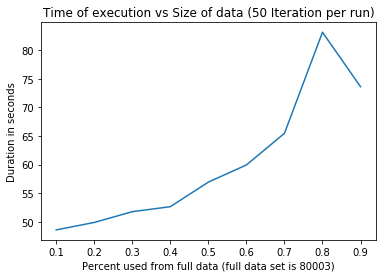

In [18]:
plt.plot(durations.set_index('percent_of_data'))
plt.title('Time of execution vs Size of data (50 Iteration per run)')
plt.xlabel('Percent used from full data (full data set is 80003)')
plt.ylabel('Duration in seconds')

print('The chart below shows the time for execution has high variability but it does not change drastically. \n\
This is probably because all test contain the same amount of users, movies and rating matrix dimensions. \n\
An alternative way to test scaling could be to remove movies and or users from the data set.')
plt.show()

In [19]:
# We now create the appropriate matrcies to for the training data and the test data

#First we create two empty matrix (train  & test) with the same dimmesions.
rawdata=rawdata_train
M = np.zeros((ratings_full.user_id.max()+1,movies.new_movieId.max()+1))
M[:,:] = np.nan

Mtest = np.zeros((ratings_full.user_id.max()+1,movies.new_movieId.max()+1))
Mtest[:,:] = np.nan

# Now we populate the training matrix with training ratings
rawdata = np.asanyarray(rawdata)
for uid, mid, rating in rawdata:
    M[int(uid),int(mid)] = rating
    
# We make use of masks to easily identify the cells with an actual rating
MTF = ~np.isnan(M)
M0 = np.nan_to_num(M)

# Here we populate the test matrix with the test ratings
rawdata = rawdata_test
rawdata = np.asanyarray(rawdata)
for uid, mid, rating in rawdata:
    Mtest[int(uid),int(mid)] = rating

MtestTF = ~np.isnan(Mtest)

### How many ratings do we have for each movie?
We want to see how sparse our data is, so let's plot the average and median number of ratings per movie. 

 
 The chart below shows that most movies have less than 8 ratings


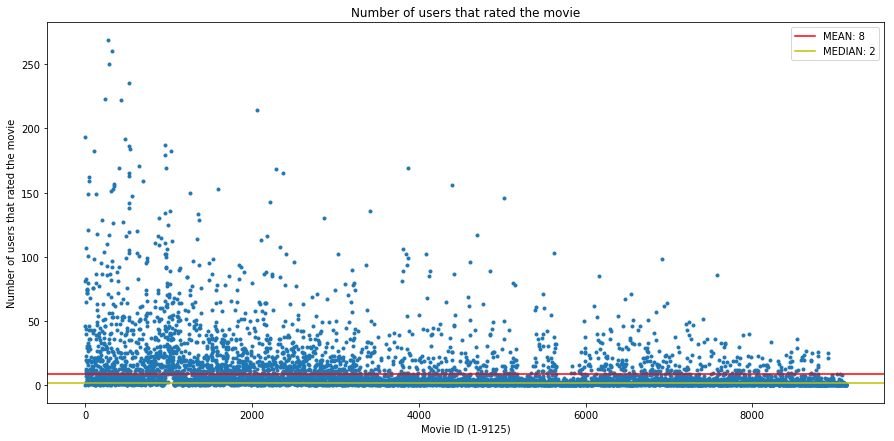

In [20]:
# Show the number of ratings per movie
temp = MTF.sum(axis=0)
avg = temp.mean()
mid = np.median(temp)

plt.figure(figsize=(15,7))
#plt.plot(MTF.sum(axis=0))
plt.scatter(range(temp.shape[0]), MTF.sum(axis=0), marker='.')
plt.axhline(y=avg, color='r', label='MEAN: %i' %int(avg) )
plt.axhline(y=mid, color='y', label='MEDIAN: %i' %int(mid) )
plt.title('Number of users that rated the movie')
plt.xlabel('Movie ID (1-9125)')
plt.ylabel('Number of users that rated the movie')
plt.legend()
print(' \n', 'The chart below shows that most movies have less than 8 ratings')
plt.show()

In [21]:
# We add this number to the movies matrix becuase they will provide a good idea of how much information we have about each movie.

temp = pd.DataFrame(MTF.sum(axis=0)).reset_index()
temp = movies.merge(temp, how='left', left_on='new_movieId', right_on='index')
temp = temp.rename(columns={0:'ratings_count'})
temp = temp.drop('index', axis=1)
movies = temp
movies.head()

,new_movieId,movieId,title,ratings_count
0,1,1,Toy Story (1995),193
1,2,2,Jumanji (1995),81
2,3,3,Grumpier Old Men (1995),46
3,4,4,Waiting to Exhale (1995),11
4,5,5,Father of the Bride Part II (1995),44


### Parameter optimization and model execution

Let's run the model with different parameters and choose the set of parameters that results in the lowest RMSE.

In [22]:
#%% Now we will run the movdel with different parameters and choose the one with the lowers RMSE

ds= [10, 15] # The number of factors
sigmas = [.5, 1] # The learning rate
lams = [1, 5] # The regularization parameter

iterations = 50 # Number of epochs
rounds = (len(ds)*len(sigmas)*len(lams))

In [23]:
# This cell will run the model for each combination of the the parameters. It will also choose the model with the lowest RMSE.

# We create some tables to capture metadata about the model execution
objective_all = np.zeros((iterations,rounds))
rmse_all = np.zeros((iterations,rounds))
cols = ['round','factors','sigma','lambda','mae','rmse', 'objective']
rmse_obj = pd.DataFrame(np.zeros((rounds,len(cols))), columns= cols)
objective_best = 0
rmse_best=1000

# Now we run the model for all the parameter combinations
for r,combination in enumerate(itertools.product(ds, sigmas, lams)):
    d = combination[0]
    sigma = combination[1]
    lam = combination[2]

    #Initialize U and V
    U = np.random.randn(M.shape[0],d)
    V = np.random.randn(d,M.shape[1])
    #V = pd.read_csv('v_init_jc.csv',header= None)
    #V = np.asanyarray(V)
    
    omega = np.nan_to_num(np.divide(M,M))
    objective = np.array([])
    rmse_temp = np.array([])
    
    #
    for n in range(iterations):
        #
    
        for i in range(M.shape[0]):
            #temp = V.dot(omega[i]*np.identity(len(omega[i]))).dot(V.T)
            #
            mask = MTF[i,:]
            temp = V[:,mask].dot(V[:,mask].T)
            temp = lam*sigma*np.identity(len(temp)) + temp
            temp = np.linalg.inv(temp)
            #temp = temp.dot(V.dot(M0[i]))
            temp = temp.dot(V[:,mask].dot(M[i,:][mask]))
            U[i] = temp
        #  
        for j in range(M.shape[1]):
            #temp = U.T.dot(omega[:,j]*np.identity(len(omega[:,j]))).dot(U)
            mask = MTF[:,j]
            temp = U.T[:,mask].dot(U.T[:,mask].T)
            temp = lam*sigma*np.identity(len(temp)) + temp
            temp = np.linalg.inv(temp)
            #temp = temp.dot(U.T.dot(M0[:,j]))  # Are the indexs correct?
            temp = temp.dot(U.T[:,mask].dot(M[:,j][mask]))
            V[:,j] = temp
        #print(n, ':iteration  ', r, ':Round', d, ':d', sigma, 'sigma', lam, ':Lambda')
    
        # Get all my predictions
        Mguess = U.dot(V)
        
        # COLLECT OUTPUTS:  
        # Calculate my Objective function for each iteration
        #temp = omega * Mguess
        #temp = (1/(2*sigma)) * np.abs(M0 - temp)**2
        temp = (1/(2*sigma)) * np.linalg.norm(M[MTF] - Mguess[MTF])**2
        
        #temp = temp.sum()       
        temp = -temp - ((lam/2)*(np.linalg.norm(U)**2)) - ((lam/2)*(np.linalg.norm(V)**2)) 
        
        # Calculate my RMSE
 
        objective = np.append(objective, temp)
        
        # Calculate RMSE for each iteration
        temp2 = np.sqrt(((Mguess[MtestTF] - Mtest[MtestTF])**2).mean())
        rmse_temp = np.append(rmse_temp, temp2)
        
        if n%20 == 0:
            print(n, ':iteration  ', r, ':Round', d, ':d', sigma, 'sigma', lam, ':Lambda', object)
        
    objective_all[:,r] = objective
    rmse_all[:,r] = rmse_temp
    # Save the best V

    if rmse_temp[-1]< rmse_best:
        rmse_best = rmse_temp[-1]
        V_final = V
        U_final = U
        Mguess_final = Mguess
        r_final = r
        print(r,' Best Round')
    print(r, ' :Round', rmse_temp[-1], ' :rmse', rmse_best, ' : best rmse')
    # Calculate the RMSE
    mae = (np.abs(Mguess[MtestTF] - Mtest[MtestTF]).sum())/MtestTF.sum()
    rmse = np.sqrt((((Mguess[MtestTF] - Mtest[MtestTF])**2).sum())/MtestTF.sum())
    rmse_obj.iloc[r] = [r, d, sigma, lam, mae, rmse, objective[-1]] #add temp to add the objective back in

0 :iteration   0 :Round 10 :d 0.5 sigma 1 :Lambda <class 'object'>
20 :iteration   0 :Round 10 :d 0.5 sigma 1 :Lambda <class 'object'>
40 :iteration   0 :Round 10 :d 0.5 sigma 1 :Lambda <class 'object'>
0  Best Round
0  :Round 1.45081667139  :rmse 1.45081667139  : best rmse
0 :iteration   1 :Round 10 :d 0.5 sigma 5 :Lambda <class 'object'>
20 :iteration   1 :Round 10 :d 0.5 sigma 5 :Lambda <class 'object'>
40 :iteration   1 :Round 10 :d 0.5 sigma 5 :Lambda <class 'object'>
1  Best Round
1  :Round 1.28905482771  :rmse 1.28905482771  : best rmse
0 :iteration   2 :Round 10 :d 1 sigma 1 :Lambda <class 'object'>
20 :iteration   2 :Round 10 :d 1 sigma 1 :Lambda <class 'object'>
40 :iteration   2 :Round 10 :d 1 sigma 1 :Lambda <class 'object'>
2  :Round 1.36756764011  :rmse 1.28905482771  : best rmse
0 :iteration   3 :Round 10 :d 1 sigma 5 :Lambda <class 'object'>
20 :iteration   3 :Round 10 :d 1 sigma 5 :Lambda <class 'object'>
40 :iteration   3 :Round 10 :d 1 sigma 5 :Lambda <class 'object'

In [24]:
print('This shows the rmse and the correlating parameter of each round')
print('Round:', r_final, ' was the one with the lowest RMSE and it will be the model used goin forward.')
rmse_obj

This shows the rmse and the correlating parameter of each round
Round: 3  was the one with the lowest RMSE and it will be the model used goin forward.


,round,factors,sigma,lambda,mae,rmse,objective
0,0.0,10.0,0.5,1.0,1.045654,1.450817,-30093.044126
1,1.0,10.0,0.5,5.0,0.931735,1.289055,-63589.541424
2,2.0,10.0,1.0,1.0,0.985684,1.367568,-19164.009461
3,3.0,10.0,1.0,5.0,0.897962,1.239245,-50266.659755
4,4.0,15.0,0.5,1.0,1.140034,1.554416,-23563.284910
5,5.0,15.0,0.5,5.0,0.964183,1.315219,-58150.593409
6,6.0,15.0,1.0,1.0,1.067139,1.457452,-16101.250035
7,7.0,15.0,1.0,5.0,0.920013,1.257149,-48327.913238


### Model performance

The chart below shows the objective function calculated against the training data.
It is interesting that the round with the best objective function is not the one with the lowest RMSE.
This may be due to the fact that some combination of parameters result in overfitting


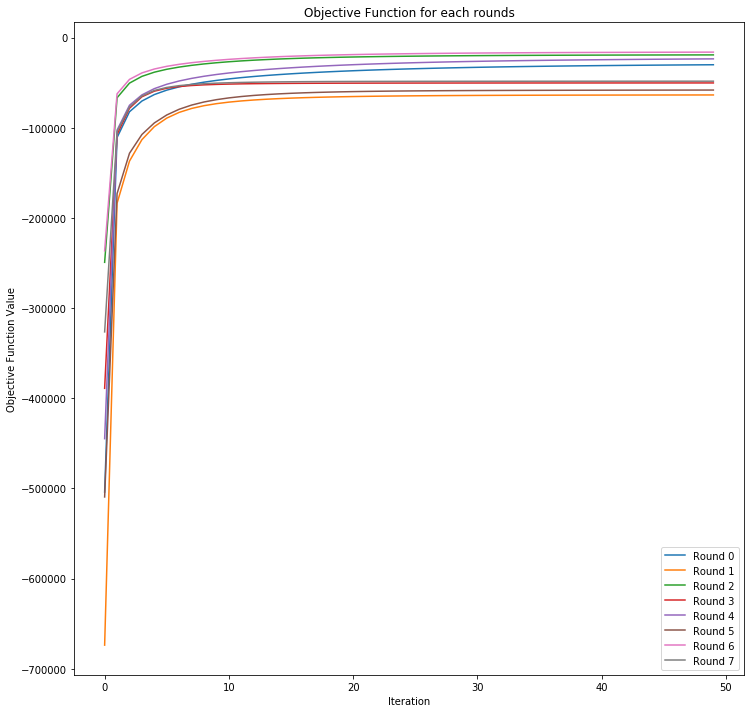

In [25]:
#%%     Plot objective function
temp = pd.DataFrame(objective_all)
plt.figure(figsize=(12,12))
for i in range(rounds):
    #plt.scatter(range(1,100), objective_all[:,i], alpha= .5, s= 15, label= 'Round %i' %(i+1))
    plt.plot(objective_all[:,i], label= 'Round %i' %(i))
    plt.legend()
    plt.title('Objective Function for each rounds')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
print('The chart below shows the objective function calculated against the training data.\n\
It is interesting that the round with the best objective function is not the one with the lowest RMSE.\n\
This may be due to the fact that some combination of parameters result in overfitting')
plt.show()

The plot below shows that performance for each combination of model parameters


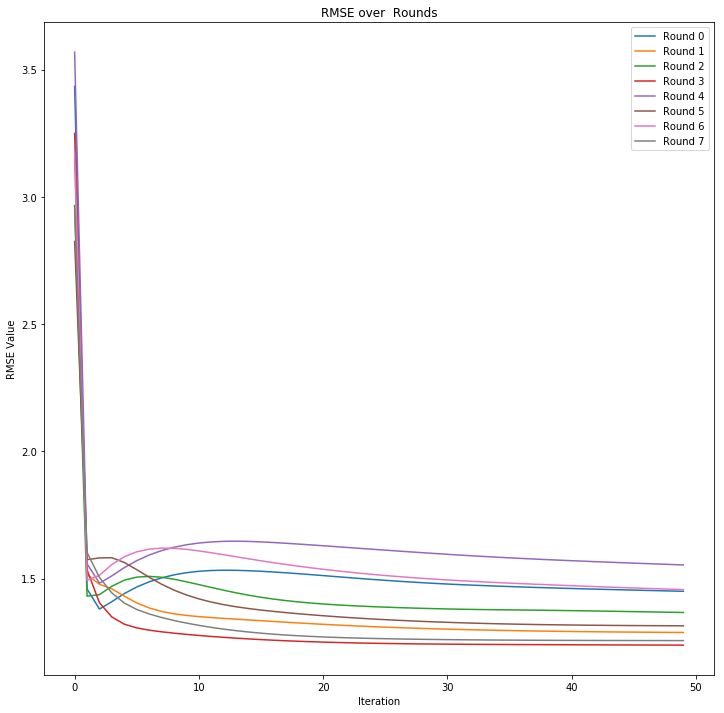

In [26]:
#%%     Plot RMSE for each round across each iteration
temp = pd.DataFrame(rmse_all)
plt.figure(figsize=(12,12))
for i in range(rounds):
    #plt.scatter(range(1,100), objective_all[:,i], alpha= .5, s= 15, label= 'Round %i' %(i+1))
    plt.plot(rmse_all[:,i], label= 'Round %i' %(i))
    plt.legend()
    plt.title('RMSE over  Rounds')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE Value')
print('The plot below shows that performance for each combination of model parameters')
plt.show()

### Find the 10 closest movies
First search a movie, then select the new_movieId.
We will first search for "Star Wars"


In [27]:
#%% Find your movie
searchmovie = 'Star Wa'


mask = movies.title.str.contains(searchmovie,case=False)
movies[mask][['title','ratings_count','new_movieId']]
#Input new_movieId on cell below

,title,ratings_count,new_movieId
232,Star Wars: Episode IV - A New Hope (1977),223,233
953,Star Wars: Episode V - The Empire Strikes Back...,187,954
966,Star Wars: Episode VI - Return of the Jedi (1983),169,967
2103,Star Wars: Episode I - The Phantom Menace (1999),113,2104
4103,Star Wars: Episode II - Attack of the Clones (...,68,4104
6139,Star Wars: Episode III - Revenge of the Sith (...,53,6140
7023,Star Wars: The Clone Wars (2008),2,7024
7570,Empire of Dreams: The Story of the 'Star Wars'...,1,7571
8783,Star Wars: Episode VII - The Force Awakens (2015),26,8784


In [28]:
# Enter your Newmovie ID
selectmovieId = 967


mask = movies.new_movieId == selectmovieId
selectmovie_act = movies[mask]['title'].values[0]

Here are the top 20 recommendations for users looking for "Star Wars: Episode VI"

In [29]:
movie_dist = np.zeros((V.shape[1],1))
for i in range(V.shape[1]):
    movie_dist[i,0] = np.linalg.norm( V_final[:,selectmovieId] - V_final[:,i])
movie_dist_df = pd.DataFrame(movie_dist, columns= [selectmovie_act])
#movie_dist_df.head()
temp = movie_dist_df.sort_values(by= selectmovie_act).iloc[1:21,:].loc[:,selectmovie_act].reset_index()
temp = temp.merge(movies[['new_movieId','title']], how='left', left_on='index', right_on='new_movieId')
temp[[selectmovie_act,'title']]

,Star Wars: Episode VI - Return of the Jedi (1983),title
0,0.452798,"Lord of the Rings: The Fellowship of the Ring,..."
1,0.474249,"Matrix, The (1999)"
2,0.491451,Raiders of the Lost Ark (Indiana Jones and the...
3,0.504063,Star Wars: Episode IV - A New Hope (1977)
4,0.529420,"Terminator, The (1984)"
5,0.538637,"Lord of the Rings: The Two Towers, The (2002)"
6,0.548636,Back to the Future (1985)
7,0.550484,Face/Off (1997)
8,0.555719,"Abyss, The (1989)"
9,0.562094,Rocky (1976)


The recommendations generated by the matrix factorization look good - as expected, the other Star Wars movies are recommended. We would feel comfortable putting the matrix factorization model in front of customers. We would want to filter the recommendations for the films that are actually in the Netflix catalog.

Some potential things to watch out for:
* Many films have few ratings. In fact the median number of ratings for each movie is 2. Given that low number, many of our films will not have enough ratings to get an accurate prediction.
* Scaling: We know that an increase in the number of ratings from already existing users to already existing movies will not drastically change the runtime of the algorithm. However, if we increase both users and movies, we don't know whether the runtime of algorithm will get worse or not.